# Simple Neural Attentive Meta-Learner (SNAIL)

TODO: Allow GPU

TODO: Fix multiprocessing warning from num_workers in torch

In [1]:
# Ignore InterpolationMode warnings from torchmeta
import warnings
warnings.filterwarnings("ignore")

## Imports

In [2]:
from collections import OrderedDict
import math
import os

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchmeta.datasets.helpers import omniglot
from torchmeta.utils.data import BatchMetaDataLoader

## Classes

### Embedding Network

![](images/omniglot_embedding.png)

In [3]:
class EmbeddingNet(nn.Module):
    def __init__(self, x_dim=1, hid_dim=64, z_dim=64):
        super(EmbeddingNet, self).__init__()
        self.encoder = nn.Sequential(
            EmbeddingNet._conv_block(x_dim, hid_dim),
            EmbeddingNet._conv_block(hid_dim, hid_dim),
            EmbeddingNet._conv_block(hid_dim, hid_dim),
            EmbeddingNet._conv_block(hid_dim, z_dim),
        )

    @staticmethod
    def _conv_block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels, momentum=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def forward(self, x):
        x = self.encoder(x)
        out = x.view(x.size(0), -1)

        return out

### SNAIL Architecture

#### Causal Convolution

In [4]:
# TODO: Use this instead: https://github.com/pytorch/pytorch/issues/1333#issuecomment-400338207 ?
class CasualConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super(CasualConv1d, self).__init__()
        self.dilation = dilation
        padding = dilation * (kernel_size - 1)
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)

    def forward(self, input_):
        # Takes something of shape (N, in_channels, T), returns (N, out_channels, T)
        out = self.conv1d(input_)
        return out[:, :, :-self.dilation] # TODO: make this correct for different strides/padding

#### Dense Block

![](images/snail_dense_block.png)

In [5]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, dilation, filters, kernel_size=2):
        super(DenseBlock, self).__init__()
        self.causal_conv1 = CasualConv1d(in_channels, filters, kernel_size, dilation=dilation)
        self.causal_conv2 = CasualConv1d(in_channels, filters, kernel_size, dilation=dilation)

    def forward(self, input_):
        # input is dimensions (N, in_channels, T)
        xf = self.causal_conv1(input_)
        xg = self.causal_conv2(input_)
        activations = torch.tanh(xf) * torch.sigmoid(xg) # shape: (N, filters, T)

        return torch.cat((input_, activations), dim=1)

#### TC Block

![](images/snail_tc_block.png)

In [6]:
class TCBlock(nn.Module):
    def __init__(self, in_channels, seq_length, filters):
        super(TCBlock, self).__init__()
        self.dense_blocks = nn.ModuleList([DenseBlock(in_channels + i * filters, 2 ** (i+1), filters)
                                           for i in range(int(math.ceil(math.log(seq_length, 2))))])

    def forward(self, input_):
        # input is dimensions (N, T, in_channels)
        input_ = torch.transpose(input_, 1, 2)
        for block in self.dense_blocks:
            input_ = block(input_)

        return torch.transpose(input_, 1, 2)

#### Attention Block

![](images/snail_attention_block.png)

In [7]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels, key_size, value_size):
        super(AttentionBlock, self).__init__()
        self.query_layer = nn.Linear(in_channels, key_size)
        self.keys_layer = nn.Linear(in_channels, key_size)
        self.values_layer = nn.Linear(in_channels, value_size)
        self.sqrt_key_size = math.sqrt(key_size)
        self.key_size = key_size

    @staticmethod
    def CausallyMaskedSoftmax(logits, key_size):
        seq_len = logits.shape[1]
        mask = np.array([[i > j for i in range(seq_len)] for j in range(seq_len)])
        mask = torch.BoolTensor(mask)
        # mask = torch.BoolTensor(mask).cuda()
        logits = logits.data.masked_fill(mask, -float('inf'))

        return F.softmax(logits / math.sqrt(key_size), dim=1)

    def forward(self, input_):
        # input is dim (N, T, in_channels) where N is the batch_size, and T is the sequence length
        keys = self.keys_layer(input_) # shape: (N, T, key_size)
        query = self.query_layer(input_) # shape: (N, T, key_size)
        logits = torch.bmm(query, torch.transpose(keys, 1, 2)) # shape: (N, T, T)
        probs = AttentionBlock.CausallyMaskedSoftmax(logits, self.key_size) # shape: (N, T, T), broadcasting over any slice [:, x, :], each row of the matrix

        values = self.values_layer(input_) # shape: (N, T, value_size)
        read = torch.bmm(probs, values) # shape: (N, T, value_size)

        return torch.cat((input_, read), dim=2) # shape: (N, T, in_channels + value_size)

### Full Network

![](images/snail_architecture.png)

In [8]:
class SNAIL(nn.Module):
    def __init__(self, N, K):
        super(SNAIL, self).__init__()

        self.N, self.K = N, K # N-way, K-shot

        self.encoder = EmbeddingNet()
        num_channels = 64 + N
        num_filters = int(math.ceil(math.log(N * K + 1, 2)))
        self.attention1 = AttentionBlock(num_channels, 64, 32)
        num_channels += 32
        self.tc1 = TCBlock(num_channels, N * K + 1, 128)
        num_channels += num_filters * 128
        self.attention2 = AttentionBlock(num_channels, 256, 128)
        num_channels += 128
        self.tc2 = TCBlock(num_channels, N * K + 1, 128)
        num_channels += num_filters * 128
        self.attention3 = AttentionBlock(num_channels, 512, 256)
        num_channels += 256
        self.fc = nn.Linear(num_channels, N)

    def forward(self, input, labels):
        x = self.encoder(input)
        batch_size = int(labels.size()[0] / (self.N * self.K + 1))

        # TODO: Maybe move this zeroing to process_torchmeta_batch() at train.py
        last_idxs = [(i + 1) * (self.N * self.K + 1) - 1 for i in range(batch_size)]
#         labels[last_idxs] = torch.Tensor(np.zeros((batch_size, labels.size()[1]))).cuda()
        labels[last_idxs] = torch.Tensor(np.zeros((batch_size, labels.size()[1])))

        x = torch.cat((x, labels), 1)
        x = x.view((batch_size, self.N * self.K + 1, -1))
        x = self.attention1(x)
        x = self.tc1(x)
        x = self.attention2(x)
        x = self.tc2(x)
        x = self.attention3(x)
        x = self.fc(x)
        return x

## Helper Functions

In [9]:
# TODO: Improve parameter names
def get_acc(last_model, last_targets):
    _, preds = last_model.max(1)
    acc = torch.eq(preds, last_targets).float().mean()
    return acc.item()

In [10]:
# TODO: Update docstring
def process_torchmeta_batch(batch, NUM_CLS, NUM_SAMPLES):
    """
    Process batch from torchmeta dataset for the SNAIL model

    Parameters
    ----------
    batch : dict
        A dictionary given by the torchmeta dataset
    options : SimpleNamespace
        A namespace with configuration details.

    Returns
    -------
    input_images : torch.tensor
        Input images to the SNAIL model of shape (batch_size*(N*K+1), img_channels, img_height,
        img_width) where N and K denote the same variables as in the N-way K-shot problem.
    input_onehot_labels : torch.tensor
        Input one-hot labels to the SNAIL model of shape (batch_size*(N*K+1), N) where N and K
        denote the same variables as in the N-way K-shot problem. The last label for each (N*K+1)
        is not used since it is the target label.
    target_labels : torch.tensor
        Test set labels to evaluate the SNAIL model by comparing with its outputs. Has shape
        (batch_size).

    """
    train_inputs, train_labels = batch["train"]
    test_inputs, test_labels = batch["test"]

    # Select one image from N images in the test set
    chosen_indices = torch.randint(test_inputs.shape[1], size=(test_inputs.shape[0],))
    chosen_test_inputs = test_inputs[torch.arange(test_inputs.shape[0]), chosen_indices, :, :, :].unsqueeze(1)
    chosen_test_labels = test_labels[torch.arange(test_labels.shape[0]), chosen_indices].unsqueeze(1)

    # Concatenate train and test set for SNAIL-style input images and labels
    input_images = torch.cat((train_inputs, chosen_test_inputs), dim=1).reshape((-1, *train_inputs.shape[2:]))
    input_labels = torch.cat((train_labels, chosen_test_labels), dim=1).reshape((-1, *train_labels.shape[2:]))

    # Convert labels to one-hot
    input_onehot_labels = F.one_hot(input_labels).float()

    # Separate out target labels
    target_labels = input_labels[::(NUM_CLS * NUM_SAMPLES + 1)].long()

    # Move to correct device
#     if options.cuda:
#         input_images, input_onehot_labels = input_images.cuda(), input_onehot_labels.cuda()
#         target_labels = target_labels.cuda()

    return input_images, input_onehot_labels, target_labels

## Hyperparameters

In [11]:
NUM_CLS = 5     # N-way
NUM_SAMPLES = 1 # K-shot

In [12]:
N_TRAIN_EPISODES = 100
N_VAL_EPISODES = 100
N_TEST_EPISODES = 100

TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32

In [13]:
ADAM_LR = 1e-4

In [14]:
OUTPUT_DIR = "logs/snail/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [15]:
USE_CUDA =  torch.cuda.is_available()

## Loop

Main script for training SNAIL on Omniglot.

In [16]:
def train_one_episode(model, optimizer, batch, NUM_CLS, NUM_SAMPLES):
    input_images, input_onehot_labels, target_labels = process_torchmeta_batch(batch, NUM_CLS, NUM_SAMPLES)
    predicted_labels = model(input_images, input_onehot_labels)[:, -1, :]
    loss = F.cross_entropy(predicted_labels, target_labels)
    acc = get_acc(predicted_labels, target_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item(), acc

In [17]:
def test_one_episode(model, optimizer, batch, NUM_CLS, NUM_SAMPLES):
    input_images, input_onehot_labels, target_labels = process_torchmeta_batch(batch, NUM_CLS, NUM_SAMPLES)
    predicted_labels = model(input_images, input_onehot_labels)[:, -1, :]
    loss = F.cross_entropy(predicted_labels, target_labels)
    acc = get_acc(predicted_labels, target_labels)

    return loss.item(), acc

In [18]:
def train(model, optimizer, train_dataloader, val_dataloader):
    if val_dataloader is None:
        best_state = None
    train_loss_per_ep, train_acc_per_ep = [], []
    val_loss_per_ep, val_acc_per_ep = [], []
    best_val_acc = 0

    best_model_path = os.path.join(OUTPUT_DIR, 'best_model.pth')
    last_model_path = os.path.join(OUTPUT_DIR, 'last_model.pth')

    # Training phase
    model.train()
    for i, batch in tqdm(enumerate(train_dataloader), total=N_TRAIN_EPISODES):
        if i >= N_TRAIN_EPISODES: break

        train_loss, train_acc = train_one_episode(model, optimizer, batch, NUM_CLS, NUM_SAMPLES)
        train_loss_per_ep.append(train_loss)
        train_acc_per_ep.append(train_acc)

    # TODO: Don't average all episodes here
    avg_train_loss = np.mean(train_loss_per_ep)
    avg_train_acc = np.mean(train_acc_per_ep)
    print('Avg Train Loss: {}, Avg Train Acc: {}'.format(avg_train_loss, avg_train_acc))

    # Validation phase
    model.eval()
    for i, batch in tqdm(enumerate(val_dataloader), total=N_VAL_EPISODES):
        if i >= N_VAL_EPISODES: break

        val_loss, val_acc = test_one_episode(model, optimizer, batch, NUM_CLS, NUM_SAMPLES)
        val_loss_per_ep.append(val_loss)
        val_acc_per_ep.append(val_acc)

    avg_val_loss = np.mean(val_loss_per_ep)
    avg_val_acc = np.mean(val_acc_per_ep)
    postfix = ' (Best)' if avg_val_acc >= best_val_acc else ' (Best: {})'.format(best_val_acc)
    print('Avg Val Loss: {}, Avg Val Acc: {}{}'.format(avg_val_loss, avg_val_acc, postfix))

    if avg_val_acc >= best_val_acc:
        torch.save(model.state_dict(), best_model_path)
        best_val_acc = avg_val_acc
        best_state = model.state_dict()

    for name in ['train_loss_per_ep', 'train_acc_per_ep', 'val_loss_per_ep', 'val_acc_per_ep']:
        with open(os.path.join(OUTPUT_DIR, name + '.txt'), 'w') as f:
            for item in locals()[name]:
                f.write("%s\n" % item)

    torch.save(model.state_dict(), last_model_path)

    return best_state, best_val_acc, train_loss_per_ep, train_acc_per_ep, val_loss_per_ep, val_acc_per_ep

In [19]:
def test(model, test_dataloader):
    """
    Test model on given dataset and options.
    """
    model.eval()
    test_loss_per_ep, test_acc_per_ep = [], []
    for i, batch in tqdm(enumerate(test_dataloader), total=N_TEST_EPISODES):
        if i >= N_TEST_EPISODES: break

        test_loss, test_acc = test_one_episode(model, optimizer, batch, NUM_CLS, NUM_SAMPLES)
        test_loss_per_ep.append(test_loss)
        test_acc_per_ep.append(test_acc)

    avg_test_loss = np.mean(test_loss_per_ep)
    avg_test_acc = np.mean(test_acc_per_ep)
    print('Avg Test Loss: {} Avg Test Acc: {}'.format(avg_test_loss, avg_test_acc))

    return test_loss_per_ep, test_acc_per_ep

In [20]:
# Setup dataset
# TODO: Data is augmented like Santoro et al. (2016)
train_dataset = omniglot("data", ways=NUM_CLS, shots=NUM_SAMPLES, test_shots=NUM_SAMPLES, meta_train=True, download=True)
train_dataloader = BatchMetaDataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE)
val_dataset = omniglot("data", ways=NUM_CLS, shots=NUM_SAMPLES, test_shots=NUM_SAMPLES, meta_val=True, download=True)
val_dataloader = BatchMetaDataLoader(val_dataset, batch_size=VAL_BATCH_SIZE)
test_dataset = omniglot("data", ways=NUM_CLS, shots=NUM_SAMPLES, test_shots=NUM_SAMPLES, meta_test=True, download=True)
test_dataloader = BatchMetaDataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)
# Setup model
model = SNAIL(NUM_CLS, NUM_SAMPLES)
# model = model.cuda() if options.cuda else model
# Setup optimizer
optimizer = optim.Adam(params=model.parameters(), lr=ADAM_LR)

In [21]:
# Train model
train_result = train(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
)
best_state, best_val_acc, train_loss_per_ep, train_acc_per_ep, val_loss_per_ep, val_acc_per_ep = train_result

100%|████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


Avg Train Loss: 1.6251830625534058, Avg Train Acc: 0.204375


100%|████████████████████████████████████████████| 100/100 [00:40<00:00,  2.47it/s]

Avg Val Loss: 1.6033270931243897, Avg Val Acc: 0.2009375 (Best)


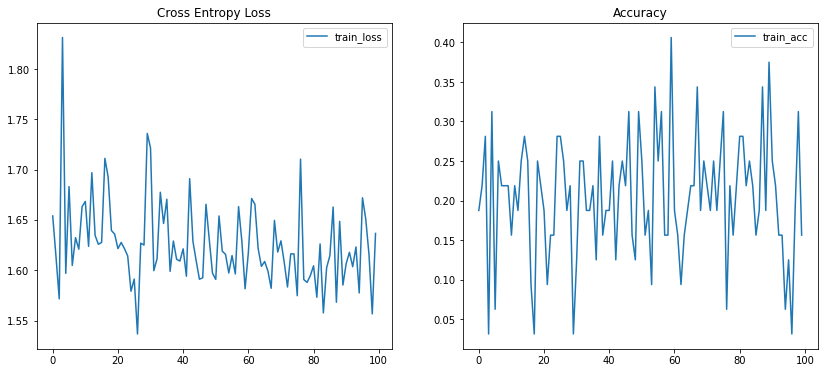

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(train_loss_per_ep, label="train_loss")
axs[0].set_title("Cross Entropy Loss")
axs[0].legend()

axs[1].plot(train_acc_per_ep, label="train_acc")
axs[1].set_title("Accuracy")
axs[1].legend()

fig.show()

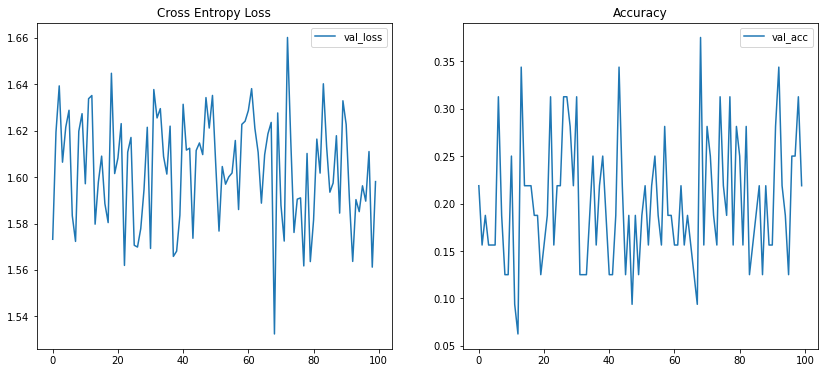

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(val_loss_per_ep, label="val_loss")
axs[0].set_title("Cross Entropy Loss")
axs[0].legend()

axs[1].plot(val_acc_per_ep, label="val_acc")
axs[1].set_title("Accuracy")
axs[1].legend()

fig.show()

In [24]:
# Test last model
last_test_loss_per_ep, last_test_acc_per_ep = test(model, test_dataloader)

100%|████████████████████████████████████████████| 100/100 [00:40<00:00,  2.49it/s]

Avg Test Loss: 1.604975641965866 Avg Test Acc: 0.2084375


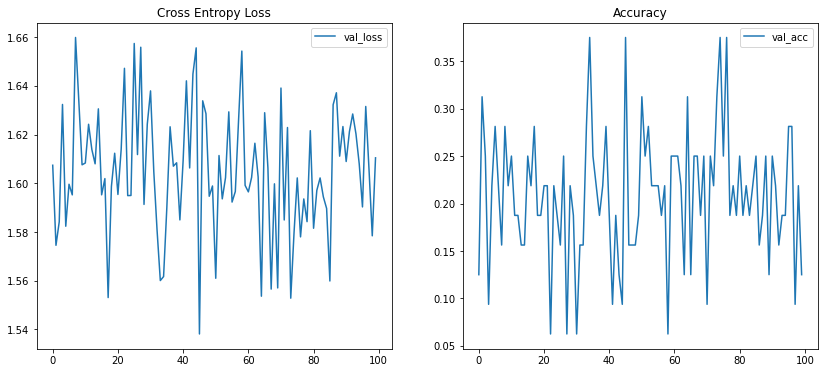

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(last_test_loss_per_ep, label="val_loss")
axs[0].set_title("Cross Entropy Loss")
axs[0].legend()

axs[1].plot(last_test_acc_per_ep, label="val_acc")
axs[1].set_title("Accuracy")
axs[1].legend()

fig.show()

In [26]:
# Test best model
model.load_state_dict(best_state)
best_test_loss_per_ep, best_test_acc_per_ep = test(model, test_dataloader)

100%|████████████████████████████████████████████| 100/100 [00:40<00:00,  2.49it/s]

Avg Test Loss: 1.6049283409118653 Avg Test Acc: 0.2034375


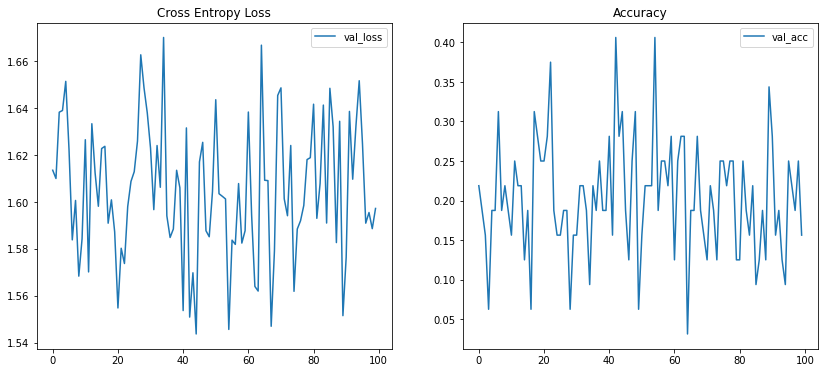

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(best_test_loss_per_ep, label="val_loss")
axs[0].set_title("Cross Entropy Loss")
axs[0].legend()

axs[1].plot(best_test_acc_per_ep, label="val_acc")
axs[1].set_title("Accuracy")
axs[1].legend()

fig.show()